#### 1. Train data set is visualized in several ways using swarmplot in seaborn to provide guidelines for feature engineering followed by one-hot encoding. A total of 6 features are used:
#### (1) Pclass and Sex are used without any modification,
#### (2) Fare is binned into 4 groups with 'unknown' and by using bin edges 10.5 and 75,
#### (3) SibSp and Parch are added together and binned to unkown, 0 (travel alone), 4 below, and 4 and above to form a new feature,
#### (4) Persons with 'Master' in Name are identified and form a new feature,
#### (5) Female in Pclass 3 with Fare > 24 is identified and forms a new feature, 
#### 2. Eight models with hyper-parameter tuning are constructed for predictions: logistic regression, random forest, gradient boosting, XGBoost, multinomial naive Bayes, k nearest neighbors, stack, and majority vote. The stack model uses all the first 6 models above as the 1st-level models and random forest as the 2nd-level model. 
#### 3. In summary, gradient boost and stack models have the highest mean cross-validation scores (both 0.842), followed by random forest and XGBoost (0.837 and 0.836, respectively), followed by logistic regression and k nearest neighbors (0.828 and 0.827, respectively), and multinomial naive Bayes has the lowest score of 0.780.
#### However, random forest, together with stack, achieve the highest public scores of 0.799, followed by logistic regression, gradient boost, and XGBoost (all 0.794), followed by k nearest neighbors with 0.789, and multinomial naive Bayes has the lowest public score of 0.746. The majority vote also achieves the highest public score of 0.799.
#### It is found that model performance (model's public score) may be highly dependent on the number of features chosen and the ways the features are enginnered.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from scipy.stats import uniform, norm
%matplotlib inline

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, \
cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier
import sklearn

## Data visualization

In [6]:
data_train = pd.read_csv('train.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
sns.set(style='darkgrid')
colors = ['darkred', 'darkseagreen']

### 1. Visualize the survival chance of persons with different fare

In [9]:
data_train[data_train['Fare'] > 300]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


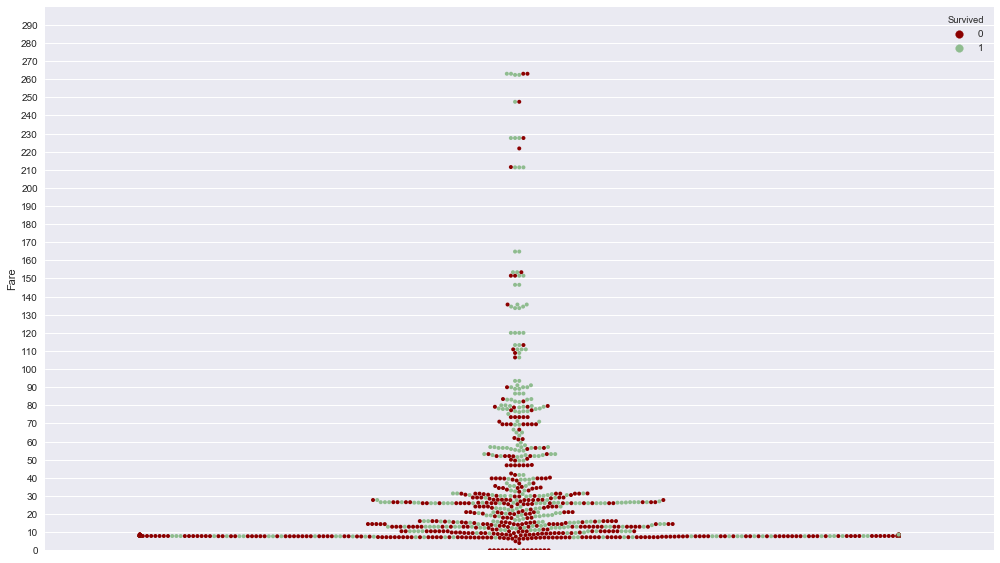

In [10]:
fig, ax = plt.subplots(figsize=(17,12))
ax.set_ylim(0, 300)
ax.set_yticks(np.arange(0, 300, 10))
sns.swarmplot(y=data_train['Fare'], x=[""]*len(data_train), size=4, 
              hue=data_train['Survived'], palette=colors)

#### The plot above shows that persons with fare above 75 had a relatively good chance of survival, and those with fare below about 10.5 the chance was quite bad, and those with fare in between seems to have a chance somewhere in the middle. 

### 2. Add 'SibSp' and 'Parch' together and visualize the chance of survival

In [11]:
df_try = data_train.copy()
df_try['SibSp_Parch'] = df_try['SibSp'] + df_try['Parch']
df_try.groupby('SibSp_Parch')['Survived'].value_counts()

SibSp_Parch  Survived
0            0           374
             1           163
1            1            89
             0            72
2            1            59
             0            43
3            1            21
             0             8
4            0            12
             1             3
5            0            19
             1             3
6            0             8
             1             4
7            0             6
10           0             7
Name: Survived, dtype: int64

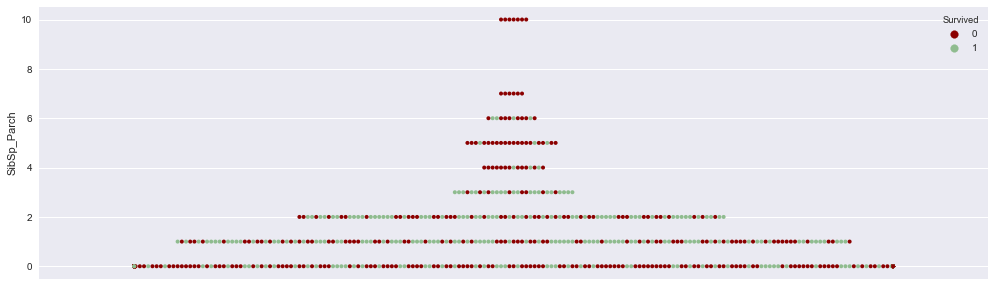

In [12]:
fig, ax = plt.subplots(figsize=(17, 7))
sns.swarmplot(y=df_try['SibSp_Parch'], x=[""]*len(df_try), size=4, hue=df_try['Survived'], 
              palette=colors)

#### The plot above shows that persons with 4 relatives or above had a relatively small chance of survival, and the same is true (to a lesser extent) with persons who traveled alone with 0 relatives. In contrast, persons with 1 to 3 relatives had a better chance of survival.   

### 3. Visualize chance of survival in plots combining sex, age, and Pclass

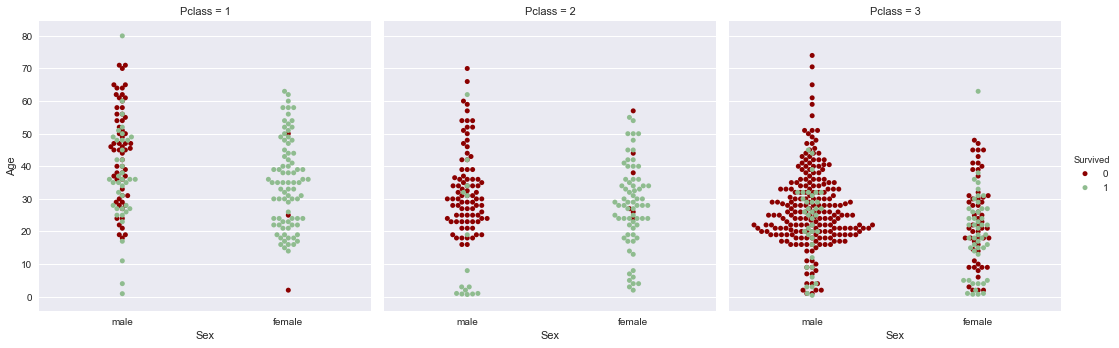

In [13]:
g1 = sns.FacetGrid(data_train, col='Pclass', hue='Survived', palette=colors, size=5, aspect=1)
g1 = g1.map(sns.swarmplot, 'Sex', 'Age', order=['male', 'female'], size=5)
g1.add_legend()

#### It can be seen from the plot above that male with age less than about 12 years old had a better chance of survival compared to male older than this age. We will later create a new feature to reflect this.

In [21]:
mask_master = pd.Series('Master' in i for i in data_train['Name'])
data_train[mask_master].sort_values('Age', ascending=False).head(10)

NameError: name 'data_train' is not defined

#### From the table above it can be seen that if a person has 'Master' in 'Name' then this person is a male with age less than or equal to 12 years old.

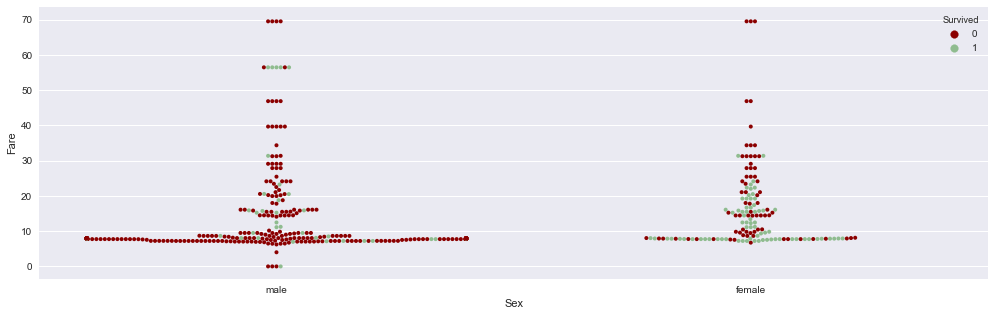

In [13]:
fig, ax = plt.subplots(figsize=(17, 5))
sns.swarmplot(x='Sex', y='Fare', data=data_train[data_train['Pclass']==3], size=4, 
              hue='Survived', palette=colors)

#### It can be seen from the plot above that female in Pclass 3 with fare greater than about 24 almost all did not make it. We will also later create a new feature to reflect this.

## Data cleaning and preprocessing

In [14]:
y = data_train['Survived']
X = data_train.drop('Survived', axis=1)
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
def combine_Sib_Par(df):
    """Sum the two columns SibSp and Parch together."""
    df['SibSp_Parch'] = df['SibSp'] + df['Parch']

def add_name_master_feature(df):
    """Create a new feature: if Master in Name, then Yes, otherwise, No."""
    mask_master = pd.Series('Master' in i for i in df['Name'])
    df1 = df['Name'].mask(mask_master, 'Yes')
    df['Name_Master'] = df1.where(mask_master, 'No')    
    
def add_female_pclass_3_high_fare_feature(df):
    """Create a new feature: if female, in Pclass 3, and Fare > 24, Yes, otherwise, No."""
    df_temp = df[((df['Pclass']==3) & (df['Sex']=='female')) & (df['Fare']>24.)]
    mask = df.index.isin(df_temp.index)
    df['Fem_Hfare_Pcl3'] = pd.Series(range(df.shape[0])).mask(mask, 'Yes')
    df['Fem_Hfare_Pcl3'] = df['Fem_Hfare_Pcl3'].where(mask, 'No')

def drop_feature(df):
    df.drop(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], \
            axis=1, inplace=True)
    
def fill_feature(df):
    """Fill all NaN values."""
    df['Pclass'] = df['Pclass'].fillna(-1)
    df['Sex'] = df['Sex'].fillna('Unknown')
    df['SibSp_Parch'] = df['SibSp_Parch'].fillna(-1)
    df['Fare'] = df['Fare'].fillna(-0.5)

def bin_fare_and_SibSpParch(df):
    """Bin Fare and SibSp_Parch based on previous visualization results."""
    bins = (-1, 0, 10.5, 75, 1500)
    group_names = ['Unknown', '10.5_below', '10.5_to_75', '75_above']
    df['Fare'] = pd.cut(df['Fare'], bins, labels=group_names, right=False)
    
    bins = (-1, -0.1, 0.1, 4, 50)
    group_names = ['Unknown', '0', '4_below', '4_above']
    df['SibSp_Parch'] = pd.cut(df['SibSp_Parch'], bins, labels=group_names, right=False)

def data_transform(df):
    combine_Sib_Par(df)
    add_name_master_feature(df)
    add_female_pclass_3_high_fare_feature(df)
    drop_feature(df)
    fill_feature(df)
    bin_fare_and_SibSpParch(df)

In [16]:
data_transform(X)

In [17]:
X.head(10)

,Pclass,Sex,Fare,SibSp_Parch,Name_Master,Fem_Hfare_Pcl3
0,3,male,10.5_below,4_below,No,No
1,1,female,10.5_to_75,4_below,No,No
2,3,female,10.5_below,0,No,No
3,1,female,10.5_to_75,4_below,No,No
4,3,male,10.5_below,0,No,No
5,3,male,10.5_below,0,No,No
6,1,male,10.5_to_75,0,No,No
7,3,male,10.5_to_75,4_above,Yes,No
8,3,female,10.5_to_75,4_below,No,No
9,2,female,10.5_to_75,4_below,No,No


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass            891 non-null int64
Sex               891 non-null object
Fare              891 non-null category
SibSp_Parch       891 non-null category
Name_Master       891 non-null object
Fem_Hfare_Pcl3    891 non-null object
dtypes: category(2), int64(1), object(3)
memory usage: 30.0+ KB


In [19]:
ohe = OneHotEncoder(handle_unknown='ignore')
X_1 = ohe.fit_transform(X).toarray()
list(X_1)[:5] 

[array([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.]),
 array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.]),
 array([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]),
 array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.]),
 array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.])]

In [20]:
ohe.categories_

[array([1, 2, 3], dtype=int64),
 array(['female', 'male'], dtype=object),
 array(['10.5_below', '10.5_to_75', '75_above'], dtype=object),
 array(['0', '4_above', '4_below'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [21]:
x_ax = ohe.get_feature_names(['Pclass', 'Sex', 'Fare', 'SibSp_Parch', 'Name_Master', 
                              'Fem_Hfare_Pcl3'])
x_ax

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Fare_10.5_below', 'Fare_10.5_to_75', 'Fare_75_above',
       'SibSp_Parch_0', 'SibSp_Parch_4_above', 'SibSp_Parch_4_below',
       'Name_Master_No', 'Name_Master_Yes', 'Fem_Hfare_Pcl3_No',
       'Fem_Hfare_Pcl3_Yes'], dtype=object)

In [22]:
# Create a DataFrame for correlation plot
X_1_frame = pd.DataFrame(X_1, columns=x_ax)
X_1_frame.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Fare_10.5_below,Fare_10.5_to_75,Fare_75_above,SibSp_Parch_0,SibSp_Parch_4_above,SibSp_Parch_4_below,Name_Master_No,Name_Master_Yes,Fem_Hfare_Pcl3_No,Fem_Hfare_Pcl3_Yes
0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


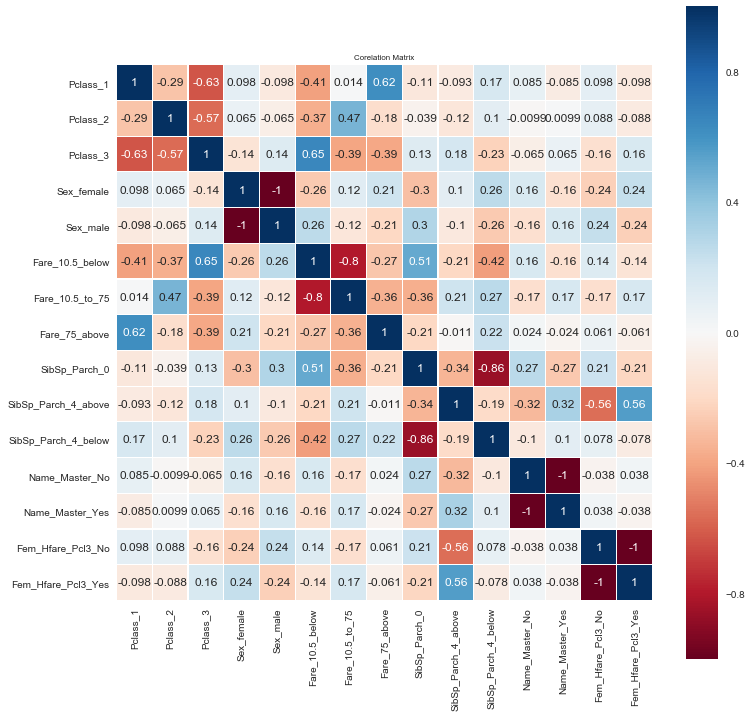

In [23]:
plt.figure(figsize=(12, 12))
plt.title('Corelation Matrix', size=8)
sns.heatmap(X_1_frame.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=plt.cm.RdBu, 
            linecolor='white', annot=True)
plt.show()

## Data training and parameter tuning

In [24]:
# define a cv splitter
cv_splitter = StratifiedKFold(n_splits=5, random_state=42)

### 1. First Model: Logistic Regressionfrom 


In [25]:
logis = LogisticRegression(solver='liblinear', random_state=42)
C_param = sorted(10**np.random.uniform(-2, 0, size=100))  # log-uniform distrbution from 0.01 to 1
# Since if there are multiple parameter combinations rank first, GridSearchCV will choose the
# first encountered one as the best result, sort the array so the smallest possible C can be 
# picked. 
parameter_grid = {
                'C': C_param,
                'class_weight': ['balanced', None]
                }
grid_logis = GridSearchCV(logis, parameter_grid, cv=cv_splitter, refit=True)
grid_logis.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=Fal...
                               0.019135880487692297, 0.020511104188433972,
                               0.020513382630874495, 0.021930485556643686,
                               0.02310201887845293, 0.023270677083837798,
                               0.023426581058204037, 0.02465844721448737,
          

In [26]:
logis_best_param = grid_logis.best_params_  
logis_best_param
# best parameter values to be used in the stack model

{'C': 0.33233042062267915, 'class_weight': None}

In [27]:
results = pd.DataFrame(grid_logis.cv_results_)
results.iloc[:,4:].sort_values('rank_test_score')

,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
199,0.941399,None,"{'C': 0.9413993046829942, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
165,0.402155,None,"{'C': 0.40215545266902863, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
183,0.658629,None,"{'C': 0.6586289317583107, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
163,0.371836,None,"{'C': 0.37183641805732065, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
185,0.697828,None,"{'C': 0.6978281265126032, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
187,0.756829,None,"{'C': 0.7568292060167616, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
159,0.35034,None,"{'C': 0.35033984911586863, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
189,0.790262,None,"{'C': 0.7902619549708225, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
161,0.35503,None,"{'C': 0.3550304858128306, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1
191,0.796945,None,"{'C': 0.7969454818643928, 'class_weight': None}",0.821229,0.826816,0.825843,0.803371,0.864407,0.828283,0.019870,1


In [28]:
x_ax = ohe.get_feature_names(['Pclass', 'Sex', 'Fare', 'SibSp_Parch', 'Name_Master', 
                              'Fem_Hfare_Pcl3'])
x_ax

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Fare_10.5_below', 'Fare_10.5_to_75', 'Fare_75_above',
       'SibSp_Parch_0', 'SibSp_Parch_4_above', 'SibSp_Parch_4_below',
       'Name_Master_No', 'Name_Master_Yes', 'Fem_Hfare_Pcl3_No',
       'Fem_Hfare_Pcl3_Yes'], dtype=object)

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x00000175D0155198>>

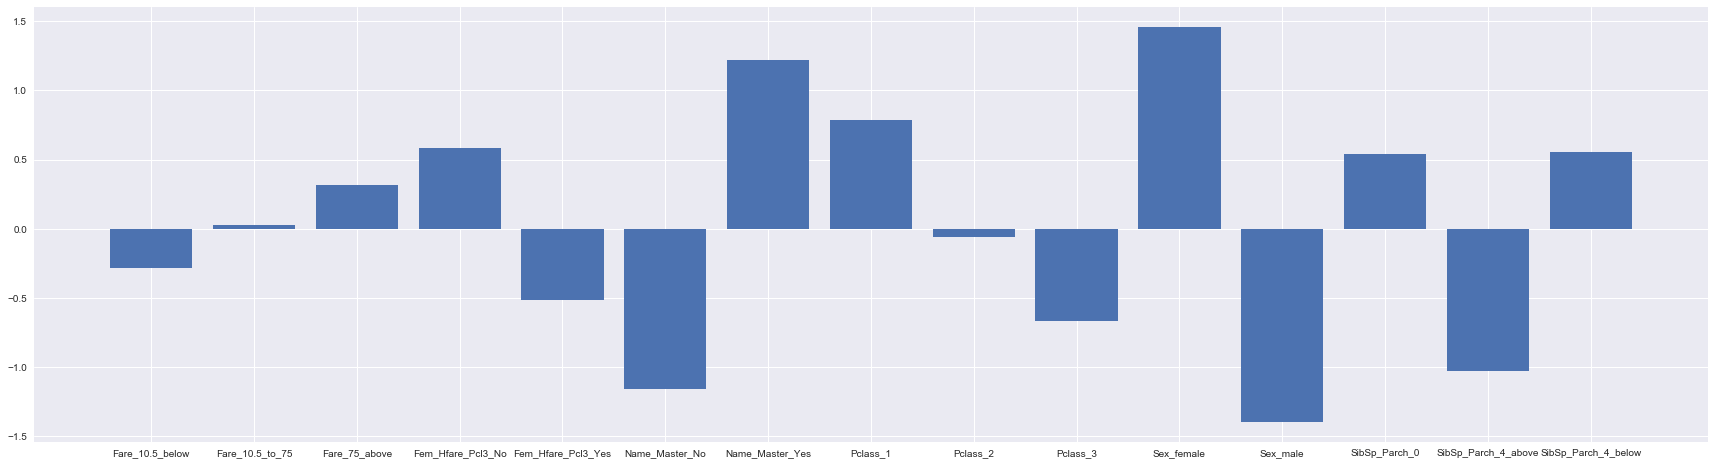

In [29]:
fig, ax = plt.subplots(figsize=(30,8))
ax.bar(x_ax, grid_logis.best_estimator_.coef_[0])
ax.grid

In [30]:
scores_logis = cross_val_score(grid_logis.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
print(scores_logis)
print('Mean (logis): '+str(scores_logis.mean()))
print('SD (logis): '+str(scores_logis.std()))

[0.82122905 0.82681564 0.8258427  0.80337079 0.86440678]
Mean (logis): 0.828332991108903
SD (logis): 0.019916825888839272


### 2. Second Model: Random Forest

In [31]:
# set max_features normal distribution sample array
num_feature = X_1.shape[1]
max_feature = norm.rvs(np.sqrt(num_feature), 2, size=200, random_state=42).astype(int)
max_feature[max_feature <= 0] = 1
max_feature[max_feature > num_feature] = num_feature
max_feature

array([4, 3, 5, 6, 3, 3, 7, 5, 2, 4, 2, 2, 4, 1, 1, 2, 1, 4, 2, 1, 6, 3,
       4, 1, 2, 4, 1, 4, 2, 3, 2, 7, 3, 1, 5, 1, 4, 1, 1, 4, 5, 4, 3, 3,
       1, 2, 2, 5, 4, 1, 4, 3, 2, 5, 5, 5, 2, 3, 4, 5, 2, 3, 1, 1, 5, 6,
       3, 5, 4, 2, 4, 6, 3, 7, 1, 5, 4, 3, 4, 1, 3, 4, 6, 2, 2, 2, 5, 4,
       2, 4, 4, 5, 2, 3, 3, 1, 4, 4, 3, 3, 1, 3, 3, 2, 3, 4, 7, 4, 4, 3,
       1, 3, 3, 8, 3, 4, 3, 1, 6, 5, 5, 2, 6, 1, 5, 8, 1, 2, 4, 2, 1, 4,
       1, 4, 2, 6, 2, 3, 5, 1, 4, 6, 1, 4, 4, 5, 1, 1, 4, 4, 4, 4, 2, 4,
       4, 2, 7, 4, 1, 5, 1, 5, 6, 2, 5, 4, 5, 7, 3, 2, 2, 2, 3, 4, 4, 5,
       3, 6, 3, 9, 5, 2, 1, 4, 3, 5, 4, 3, 2, 1, 2, 5, 4, 1, 4, 4, 2, 4,
       3, 1])

In [32]:
# set min_samples_split normal distribution sample array
min_sample_split = norm.rvs(4, 2, size=200, random_state=42).astype(int)
min_sample_split[min_sample_split <= 1] = 2
min_sample_split

array([4, 3, 5, 7, 3, 3, 7, 5, 3, 5, 3, 3, 4, 2, 2, 2, 2, 4, 2, 2, 6, 3,
       4, 2, 2, 4, 2, 4, 2, 3, 2, 7, 3, 2, 5, 2, 4, 2, 2, 4, 5, 4, 3, 3,
       2, 2, 3, 6, 4, 2, 4, 3, 2, 5, 6, 5, 2, 3, 4, 5, 3, 3, 2, 2, 5, 6,
       3, 6, 4, 2, 4, 7, 3, 7, 2, 5, 4, 3, 4, 2, 3, 4, 6, 2, 2, 2, 5, 4,
       2, 5, 4, 5, 2, 3, 3, 2, 4, 4, 4, 3, 2, 3, 3, 2, 3, 4, 7, 4, 4, 3,
       2, 3, 4, 8, 3, 4, 3, 2, 6, 5, 5, 2, 6, 2, 5, 8, 2, 2, 4, 2, 2, 4,
       2, 4, 2, 7, 2, 3, 5, 2, 4, 6, 2, 4, 4, 5, 2, 2, 5, 4, 4, 4, 2, 4,
       4, 2, 7, 4, 2, 5, 2, 5, 6, 2, 5, 4, 5, 7, 3, 2, 2, 2, 3, 4, 4, 5,
       4, 6, 3, 9, 5, 2, 2, 4, 3, 5, 4, 3, 2, 2, 3, 5, 4, 2, 4, 4, 2, 4,
       4, 2])

In [33]:
rf = RandomForestClassifier(random_state=42)
parameter_grid = {
                 'n_estimators': np.arange(50, 800, step=5),
                 'max_features': max_feature,
                 'min_samples_split': min_sample_split,
                 'min_samples_leaf': np.arange(1, 5, 1),
                 'bootstrap': [True, False]
                 }
grid_random = RandomizedSearchCV(rf, parameter_grid, n_iter=100, cv= cv_splitter, 
                                 random_state=42, refit=True, n_jobs=-1)
grid_random.fit(X_1, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_...
       440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500,
  

In [34]:
random_forest_best_param = grid_random.best_params_  
random_forest_best_param
# best parameter values to be used in the stack model

{'bootstrap': False,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 655}

In [35]:
grid_random.n_splits_

5

In [36]:
grid_random.best_estimator_.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=655,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)>

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x00000175D1AEB630>>

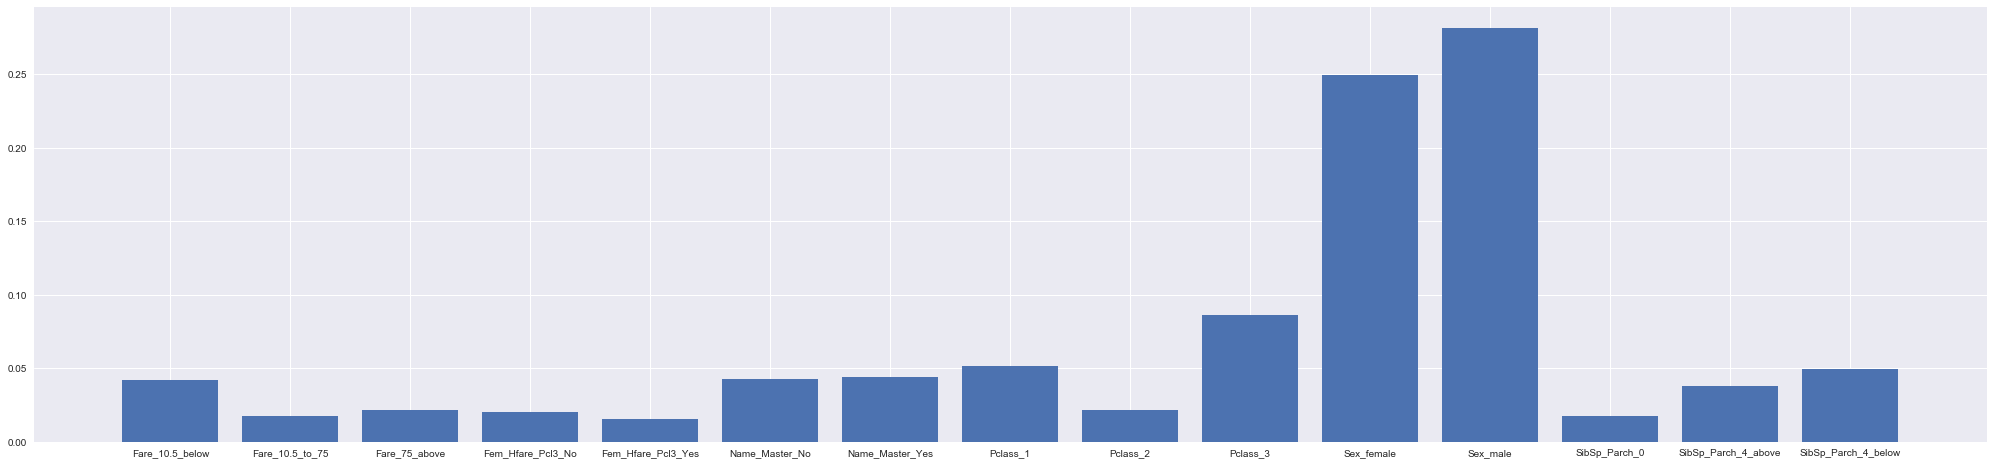

In [37]:
fig, ax = plt.subplots(figsize=(35,8))
ax.bar(x_ax, grid_random.best_estimator_.feature_importances_)
ax.grid

In [38]:
scores_random = cross_val_score(grid_random.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
print(scores_random)
print('Mean (random): '+str(scores_random.mean()))
print('SD (random): '+str(scores_random.std()))

[0.83240223 0.83798883 0.83707865 0.80898876 0.8700565 ]
Mean (random): 0.8373029948715984
SD (random): 0.019488590131932125


### 3. Third Model: Gradient Boosting

#### 1. Tune learning_rate and n_estimators

In [39]:
gb = GradientBoostingClassifier(
                                learning_rate=0.1, 
                                n_estimators=100, 
                                max_features='sqrt',
                                subsample=0.8, 
                                random_state=42
                                )
parameter_grid = {
                    'learning_rate': np.arange(0.001, 0.003, 0.0005),
                    'n_estimators': np.arange(1000, 3000, 500)
                    }
grid_gradient = GridSearchCV(gb, parameter_grid, cv=cv_splitter, n_jobs=-1)
grid_gradient.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split...
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort='auto',

In [40]:
gradient_best_param = grid_gradient.best_params_
gradient_best_param
# best parameter values to be used in the stack model

{'learning_rate': 0.002, 'n_estimators': 2500}

In [41]:
# update gb with the optimal parameters
gb.set_params(**gradient_best_param)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.002, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2500,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### 2. Tune max_depth and min_sample_split

In [42]:
parameter_grid = {
                    'max_depth': np.arange(1, 5),
                    'min_samples_split': np.arange(2, 6, 1)
                    }
grid_gradient = GridSearchCV(gb, parameter_grid, cv=cv_splitter, n_jobs=-1)
grid_gradient.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None,
                                                  learning_rate=0.002,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_spl...
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=2500,
       

In [43]:
grid_gradient.best_params_

{'max_depth': 3, 'min_samples_split': 2}

In [44]:
gradient_best_param.update(grid_gradient.best_params_)
gradient_best_param
# update best parameter values to be used in the stack model

{'learning_rate': 0.002,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 2500}

In [45]:
# update gb with the optimal parameters
gb.set_params(**gradient_best_param)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.002, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2500,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### 3. Tune max_features and subsample

In [46]:
parameter_grid = {
                    'max_features': np.arange(2, 6),
                    'subsample': np.arange(0.4, 0.8, step=0.1)
                    }
grid_gradient = GridSearchCV(gb, parameter_grid, cv=cv_splitter, n_jobs=-1)
grid_gradient.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None,
                                                  learning_rate=0.002,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_spl...
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=2500,
       

In [47]:
grid_gradient.best_params_

{'max_features': 3, 'subsample': 0.6}

In [48]:
gradient_best_param.update(grid_gradient.best_params_)
gradient_best_param
# update best parameter values to be used in the stack model

{'learning_rate': 0.002,
 'max_depth': 3,
 'max_features': 3,
 'min_samples_split': 2,
 'n_estimators': 2500,
 'subsample': 0.6}

In [49]:
grid_gradient.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.002, loss='deviance', max_depth=3,
                           max_features=3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2500,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x00000175D1C79A90>>

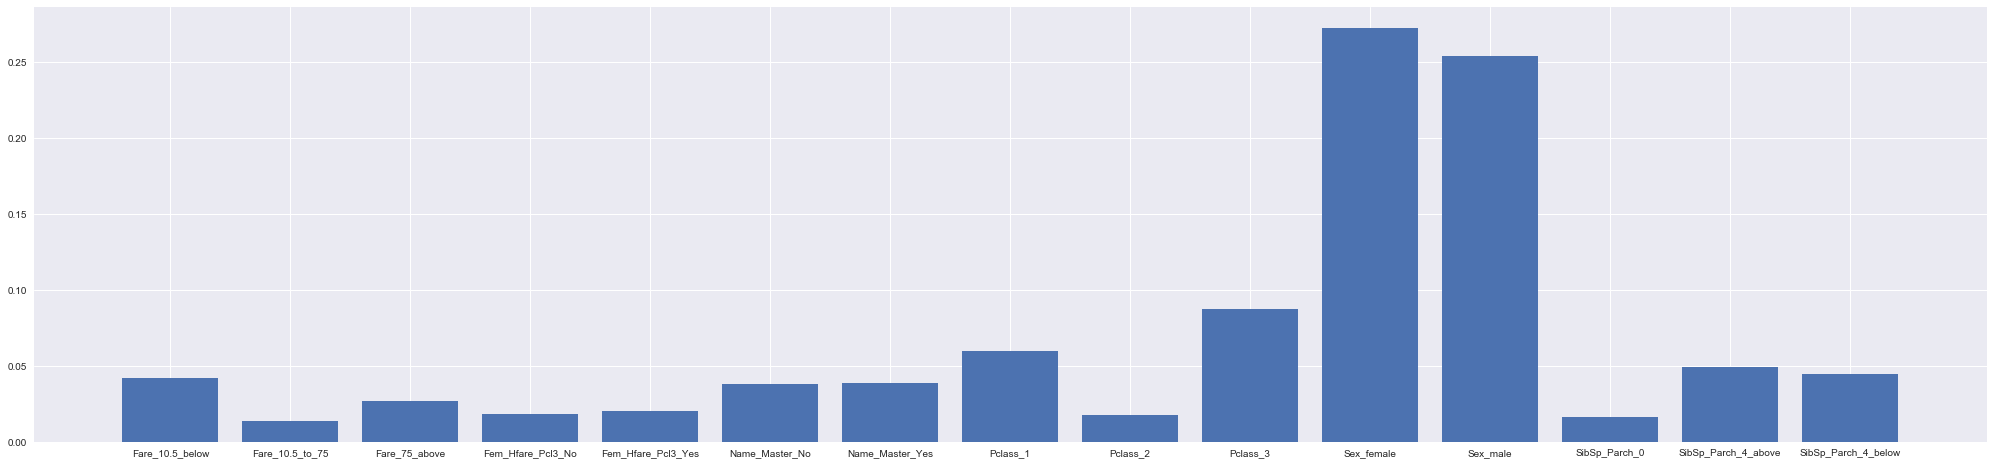

In [50]:
fig, ax = plt.subplots(figsize=(35,8))
ax.bar(x_ax, grid_gradient.best_estimator_.feature_importances_)
ax.grid

In [51]:
scores_gradient = cross_val_score(grid_gradient.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
print(scores_gradient)
print('Mean (gradient): '+str(scores_gradient.mean()))
print('SD (gradient): '+str(scores_gradient.std()))

[0.8547486  0.83798883 0.83707865 0.80898876 0.8700565 ]
Mean (gradient): 0.8417722686146151
SD (gradient): 0.020393555315705667


### 4. Fourth Model: XGBoost

#### (The tuning steps can be found in the article by Aarshay Jain at https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

#### 1. Fix learning rate at 0.01 and find the optimal number of trees (n_estimators) 

In [52]:
xgtrain = xgboost.DMatrix(X_1, label=y.values)

In [53]:
xgb = XGBClassifier(
                     learning_rate =0.01,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     n_jobs=-1,
                     random_state=42
                    )

In [54]:
xgb_param = xgb.get_xgb_params()
xgb_param

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 42,
 'subsample': 0.8,
 'verbosity': 1}

In [55]:
cvresult = xgboost.cv(xgb_param, xgtrain, 
                  num_boost_round=xgb.get_params()['n_estimators'], 
                  nfold=5,
                  metrics='auc', 
                  early_stopping_rounds=50,
                  seed=42
                  )

In [56]:
cvresult.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.873888,0.010391,0.855611,0.034021
1,0.878771,0.005563,0.869908,0.025996
2,0.879495,0.005604,0.869561,0.025799
3,0.879627,0.005452,0.869534,0.025404
4,0.880877,0.005169,0.866409,0.024275


In [57]:
cvresult.shape

(12, 4)

In [58]:
xgb_best_param = {'n_estimators': cvresult.shape[0]}
xgb_best_param
# best n_estimators value to be used in the stack model

{'n_estimators': 12}

In [59]:
# update xgb with the optimal n_estimators
xgb.set_params(**xgb_best_param)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=12, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

#### 2. Tune max_depth and min_child_weight

In [60]:
parameter_grid = {
                    'max_depth': np.arange(2, 4),
                    'min_child_weight': np.arange(1, 4)
                 }
grid_xgb = GridSearchCV(xgb, parameter_grid, cv=cv_splitter, n_jobs=-1)
grid_xgb.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=12, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': array([2, 3]),
                         'min_child_wei

In [61]:
grid_xgb.best_params_

{'max_depth': 3, 'min_child_weight': 1}

In [62]:
xgb_best_param.update(grid_xgb.best_params_)
xgb_best_param
# best parameter values to be used in the stack model

{'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 12}

In [63]:
xgb.set_params(**xgb_best_param)
# update xgb parameters

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=12, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

#### 3. Tune gamma

In [20]:
10**np.random.uniform(-3, 0, size=10)  # log-uniform distrbution from 0.001 to 1

array([0.05148264, 0.02787952, 0.31355684, 0.00426901, 0.38146994,
       0.00751314, 0.28618042, 0.05583692, 0.09626797, 0.00408049])

In [65]:
parameter_grid = {
                    'gamma': 10**np.random.uniform(-3, 0, size=10)
                 }
grid_xgb = GridSearchCV(xgb, parameter_grid, cv=cv_splitter, n_jobs=-1)
grid_xgb.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=12, n_jobs=-1,
                                     nthread=None, o...
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'gamma': array([0.00991963, 0.00457822, 0.07368577, 0.00103531, 0.00282271,
       0.005379

In [66]:
grid_xgb.best_params_

{'gamma': 0.009919628225944364}

In [67]:
results = pd.DataFrame(grid_xgb.cv_results_)
results.iloc[:,4:].sort_values('rank_test_score')

,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.00991963,{'gamma': 0.009919628225944364},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
1,0.00457822,{'gamma': 0.004578223207895638},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
2,0.0736858,{'gamma': 0.07368577362395162},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
3,0.00103531,{'gamma': 0.0010353059889022392},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
4,0.00282271,{'gamma': 0.0028227056686995385},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
5,0.00537915,{'gamma': 0.005379149806801916},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
6,0.00945409,{'gamma': 0.009454087154427781},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
7,0.0503078,{'gamma': 0.05030776640392198},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
8,0.00149891,{'gamma': 0.0014989089372106587},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
9,0.0409006,{'gamma': 0.040900608895357106},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1


In [68]:
xgb_best_param.update(grid_xgb.best_params_)
xgb_best_param
# best parameter values to be used in the stack model

{'gamma': 0.009919628225944364,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 12}

In [69]:
# update xgb with the optimal gamma
xgb.set_params(**xgb_best_param)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              gamma=0.009919628225944364, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=12,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.8, verbosity=1)

#### 4. Tune subsample and colsample_bytree

In [70]:
parameter_grid = {
                    'subsample': np.arange(0.6, 1.0, 0.1),
                    'colsample_bytree': np.arange(0.6, 1.0, 0.1)
                 }
grid_xgb = GridSearchCV(xgb, parameter_grid, cv=cv_splitter, n_jobs=-1)
grid_xgb.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8,
                                     gamma=0.009919628225944364,
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=12, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_

In [71]:
grid_xgb.best_params_

{'colsample_bytree': 0.7, 'subsample': 0.7999999999999999}

In [72]:
xgb_best_param.update(grid_xgb.best_params_)
xgb_best_param
# best parameter values to be used in the stack model

{'colsample_bytree': 0.7,
 'gamma': 0.009919628225944364,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 12,
 'subsample': 0.7999999999999999}

In [73]:
# update xgb with the optimal parameters
xgb.set_params(**xgb_best_param)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              gamma=0.009919628225944364, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=12,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7999999999999999,
              verbosity=1)

#### 5. Finally tune reg_alpha

In [74]:
parameter_grid = {
                    'reg_alpha': np.arange(0., 0.005, 0.001),
                 }
grid_xgb = GridSearchCV(xgb, parameter_grid, cv=cv_splitter, n_jobs=-1)
grid_xgb.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.7,
                                     gamma=0.009919628225944364,
                                     learning_rate=0.01, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=12, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.7999999999999999,
                                     verbosity=1),
             iid='wa

In [75]:
grid_xgb.best_params_

{'reg_alpha': 0.0}

In [76]:
results = pd.DataFrame(grid_xgb.cv_results_)
results.iloc[:,4:].sort_values('rank_test_score')

,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0,{'reg_alpha': 0.0},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
1,0.001,{'reg_alpha': 0.001},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
2,0.002,{'reg_alpha': 0.002},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
3,0.003,{'reg_alpha': 0.003},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1
4,0.004,{'reg_alpha': 0.004},0.849162,0.826816,0.831461,0.803371,0.870056,0.836139,0.022337,1


In [77]:
xgb_best_param.update(grid_xgb.best_params_)
xgb_best_param
# best parameter values to be used in the stack model

{'colsample_bytree': 0.7,
 'gamma': 0.009919628225944364,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 12,
 'reg_alpha': 0.0,
 'subsample': 0.7999999999999999}

In [78]:
grid_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              gamma=0.009919628225944364, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=12,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0.0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7999999999999999,
              verbosity=1)

#### 6. Visualize the feature importance of the final model

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x00000175D1FB6DA0>>

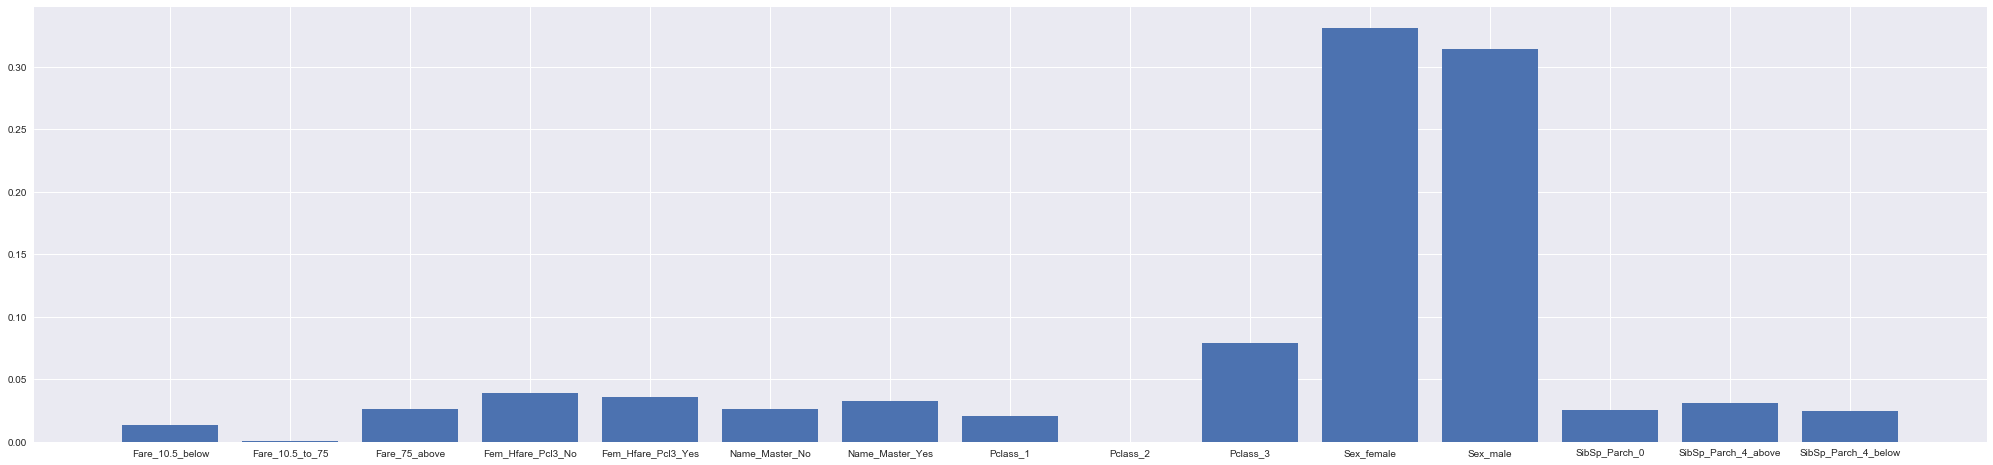

In [79]:
fig, ax = plt.subplots(figsize=(35,8))
ax.bar(x_ax, grid_xgb.best_estimator_.feature_importances_)
ax.grid

In [80]:
scores_xgb = cross_val_score(grid_xgb.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
print(scores_xgb)
print('Mean (xgb): '+str(scores_xgb.mean()))
print('SD (xgb): '+str(scores_xgb.std()))

[0.84916201 0.82681564 0.83146067 0.80337079 0.8700565 ]
Mean (xgb): 0.8361731222961166
SD (xgb): 0.022372112803258924


### 5. Fifth Model: Multinomial Naive Bayes

In [81]:
mnb = MultinomialNB()
parameters = {'alpha':np.arange(0.1, 1, 0.1)}
grid_mnb = GridSearchCV(mnb, param_grid=parameters, cv=cv_splitter, n_jobs=-1)
grid_mnb.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [82]:
grid_mnb.best_params_

{'alpha': 0.1}

In [83]:
pd.DataFrame(grid_mnb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.056027,0.026405,0.009085,0.006874,0.1,{'alpha': 0.1},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1
1,0.002170,0.000815,0.000440,0.000542,0.2,{'alpha': 0.2},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1
2,0.001824,0.001101,0.000414,0.000508,0.3,{'alpha': 0.30000000000000004},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1
3,0.001397,0.000489,0.000591,0.000727,0.4,{'alpha': 0.4},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1
4,0.001536,0.001219,0.001002,0.001554,0.5,{'alpha': 0.5},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1
5,0.002269,0.002061,0.000000,0.000000,0.6,{'alpha': 0.6},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1
6,0.002806,0.001941,0.000000,0.000000,0.7,{'alpha': 0.7000000000000001},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1
7,0.001595,0.001954,0.000800,0.001601,0.8,{'alpha': 0.8},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1
8,0.002019,0.001799,0.000833,0.001665,0.9,{'alpha': 0.9},0.681564,0.77095,0.820225,0.808989,0.819209,0.780022,0.052532,1


In [84]:
mnb_best_param = grid_mnb.best_params_
mnb_best_param

{'alpha': 0.1}

In [85]:
grid_mnb.best_estimator_

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [86]:
scores_mnb = cross_val_score(grid_mnb.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
print(scores_mnb)
print('Mean (mnb): '+str(scores_mnb.mean()))
print('SD (mnb): '+str(scores_mnb.std()))

[0.68156425 0.77094972 0.82022472 0.80898876 0.81920904]
Mean (mnb): 0.7801872978349074
SD (mnb): 0.052472955141460026


### 6. Sixth Model: K Nearest Neighbor

In [87]:
knn = KNeighborsClassifier()
parameter_grid = {
                'n_neighbors': np.arange(9, 19, 2),
                'weights': ['uniform', 'distance'],
                'metric': ['minkowski', 'manhattan'],
                'leaf_size': np.arange(10, 60, 10)
                 }
grid_knn = GridSearchCV(knn, parameter_grid, cv=cv_splitter, n_jobs=-1)
grid_knn.fit(X_1, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'leaf_size': array([10, 20, 30, 40, 50]),
                         'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': array([ 9, 11, 13, 15, 17]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [88]:
grid_knn.best_params_

{'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 11,
 'weights': 'distance'}

In [89]:
results = pd.DataFrame(grid_knn.cv_results_)
results.iloc[:,4:].sort_values('rank_test_score')

,param_leaf_size,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,20,manhattan,13,distance,"{'leaf_size': 20, 'metric': 'manhattan', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
95,50,manhattan,13,distance,"{'leaf_size': 50, 'metric': 'manhattan', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
45,30,minkowski,13,distance,"{'leaf_size': 30, 'metric': 'minkowski', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
25,20,minkowski,13,distance,"{'leaf_size': 20, 'metric': 'minkowski', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
55,30,manhattan,13,distance,"{'leaf_size': 30, 'metric': 'manhattan', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
23,20,minkowski,11,distance,"{'leaf_size': 20, 'metric': 'minkowski', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
85,50,minkowski,13,distance,"{'leaf_size': 50, 'metric': 'minkowski', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
65,40,minkowski,13,distance,"{'leaf_size': 40, 'metric': 'minkowski', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
33,20,manhattan,11,distance,"{'leaf_size': 20, 'metric': 'manhattan', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1
75,40,manhattan,13,distance,"{'leaf_size': 40, 'metric': 'manhattan', 'n_ne...",0.837989,0.787709,0.837079,0.808989,0.864407,0.827160,0.026409,1


In [90]:
knn_best_param = grid_knn.best_params_
knn_best_param

{'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 11,
 'weights': 'distance'}

In [91]:
grid_knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')

In [92]:
scores_knn = cross_val_score(grid_knn.best_estimator_, X_1, y, cv=cv_splitter, n_jobs=-1)
print(scores_knn)
print('Mean (knn): '+str(scores_knn.mean()))
print('SD (knn): '+str(scores_knn.std()))

[0.83798883 0.7877095  0.83707865 0.80898876 0.86440678]
Mean (knn): 0.8272345038827401
SD (knn): 0.02641769849631551


### 7. Compare Results of the above 5 Models

In [135]:
cross_val_results = pd.Series([scores_logis, scores_random, scores_gradient, 
                       scores_xgb, scores_mnb, scores_knn], 
            index=['Logistic', 'Random Forrest', 'Gradirnt Boost', 'XGBoost', 'MN Bayes', 'Knn'])

Text(0.5,0.98,'Mean of Cross-Validation Scores')

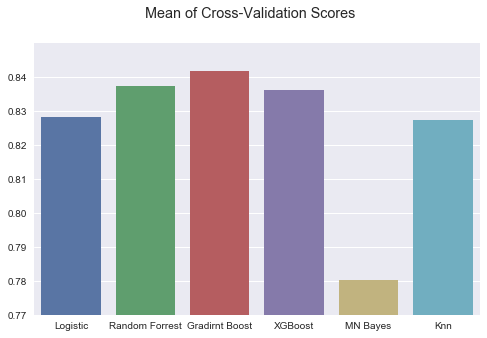

In [146]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=cross_val_results.index, y=cross_val_results.apply(np.mean))
ax.set_ylim(0.77, 0.85)
ax.set_yticks(np.arange(0.77, 0.85, step=0.01))
fig.suptitle('Mean of Cross-Validation Scores')

Text(0.5,0.98,'Standard Deviation of Cross-Validation Scores')

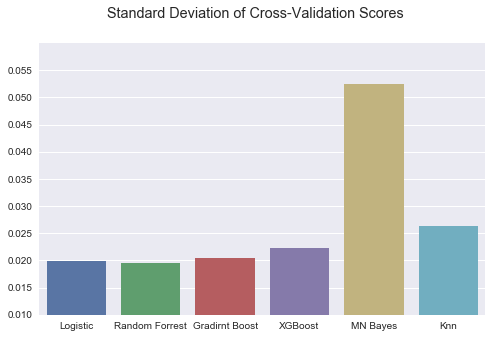

In [143]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=cross_val_results.index, y=cross_val_results.apply(np.std))
ax.set_ylim(0.01, 0.06)
ax.set_yticks(np.arange(0.01, 0.06, step=0.005))
fig.suptitle('Standard Deviation of Cross-Validation Scores')

### 8. Seventh Model: Stackiing
#### (1) In stacking, kFold cross-validated predictions of 1st-level models are used as input (where the 1st-level models become the new features) for training by a 2nd-level model. 
#### (2) Cross-validated 1st-level models are also used to predict (not train) on the test data set and the outcome (with 1st-level models as the new features) are used as input to the final prediction by the 2nd-level model.   
#### (3) Some discussions and code can be found at https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python, https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html.

#### 1. First test data need to be processed and encoded in the same way as train data (Cross-validated 1st-level models will predict (not train) on the data and the outcome becomes input to the final prediction of the 2nd-level model).    

In [93]:
data_test = pd.read_csv('test.csv')
passenger_id = data_test['PassengerId']
num_row_test = data_test.shape[0]
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [94]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [95]:
data_transform(data_test)
data_test.head()

,Pclass,Sex,Fare,SibSp_Parch,Name_Master,Fem_Hfare_Pcl3
0,3,male,10.5_below,0,No,No
1,3,female,10.5_below,4_below,No,No
2,2,male,10.5_below,0,No,No
3,3,male,10.5_below,0,No,No
4,3,female,10.5_to_75,4_below,No,No


In [96]:
X_test = ohe.transform(data_test).toarray()
list(X_test)[:5]

[array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]),
 array([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.]),
 array([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]),
 array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.]),
 array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.])]

#### 2. Define 1st-level models (using the optimal hyperparameters previously) 

In [97]:
logis = LogisticRegression(solver='liblinear', random_state=42)
logis.set_params(**logis_best_param)

LogisticRegression(C=0.33233042062267915, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
rf = RandomForestClassifier(random_state=42)
rf.set_params(**random_forest_best_param)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=655,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [99]:
gb = GradientBoostingClassifier(random_state=42)
gb.set_params(**gradient_best_param)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.002, loss='deviance', max_depth=3,
                           max_features=3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=2500,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=0.6, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [100]:
xgb = XGBClassifier(learning_rate=0.01, n_jobs=-1, random_state=42)
xgb.set_params(**xgb_best_param)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7,
              gamma=0.009919628225944364, learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=12,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0.0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7999999999999999,
              verbosity=1)

In [101]:
mnb = MultinomialNB()
mnb.set_params(**mnb_best_param)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [102]:
knn = KNeighborsClassifier()
knn.set_params(**knn_best_param)

KNeighborsClassifier(algorithm='auto', leaf_size=20, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')

#### 3. Prepare 2nd-level training and test data

In [103]:
folds = 5
skf = StratifiedKFold(n_splits=folds, random_state=42)

In [104]:
def get_oof(clf_, X_1_, y_, X_test_, folds_):
    """ Obtain out-of-fold predictions of a model on train and test data sets. 
    
    Parameters:
    ----------
    clf_: sklearn classifier
            a 1st-level model
    X_1_: numpy array
            train data with shape (891, 15)
    y_: pandas series
            train data labels with a shape (891,)
    X_test_: numpy array
            test data with shape (418, 15)
    folds: int
            number of folds in stratified K-fold cross validator
    
    Returns:
    --------
    X_train_oof: numpy array
            2nd-level train data: out-of-fold predictions of clf_ with shape (891,)
    X_test_oof: numpy array
            2nd-level test data: mean of out-of-fold predictions of clf_ on test data with 
            shape (418,)
    """

    X_train_oof = np.zeros((X_1_.shape[0],))    # 2nd-level train data with shape (891,)
    X_test_oof = np.zeros((X_test_.shape[0],))  # 2nd-level test data with shape (418,)
    X_test_oof_folds = np.zeros((folds_, X_test_.shape[0]))  
    # with shape (5, 418), a temporary array holding out-of-fold predictions of clf_ on test data 

    for i, (train_index, valid_index) in enumerate(skf.split(X_1_, y_)):  
        # i: out-of-fold group index (e.g. 0)
        # train_index: numpy array holding all train X_1_ and y_ row indices (e.g. from 179-890) 
        # valid_index: numpy array holding all valid X_1_ and y_ row indices (e.g. from 1-178)

        X_train_folds = X_1_[train_index]        # select data for train folds
        y_train_folds = y_[train_index]          # select labels for train folds 
        clf_.fit(X_train_folds, y_train_folds)   # train clf_ on train folds
        
        X_train_valid_fold = X_1_[valid_index]   # select data for valid (out-of-fold) fold
        X_train_oof[valid_index] = clf_.predict(X_train_valid_fold)  
        # clf_ predicts on valid fold and save to 2nd-level train data

        X_test_oof_folds[i, :] = clf_.predict(X_test_)
        # clf_ predicts on the entire set of test data and save the results to the i-th row in the
        # temporary array X_test_oof_folds

    X_test_oof = X_test_oof_folds.mean(axis=0)  
    # calculate the mean of out-of-fold predcitons by collapsing in the 0-th axid (with 5 rows) 
    
    return X_train_oof, X_test_oof

In [105]:
# construct 2nd-level train and test data
clfs = [logis, rf, gb, xgb, mnb, knn]
X_train_oof_final = np.zeros((X_1.shape[0], len(clfs)))       # with shape (891, 5)
X_test_oof_final = np.zeros((X_test.shape[0], len(clfs)))     # with shape (418, 5)

for i, clf in enumerate(clfs):
    clf_train_off, clf_test_off = get_oof(clf, X_1, y, X_test, folds)
    X_train_oof_final[:, i] = clf_train_off
    X_test_oof_final[:, i] = clf_test_off

In [106]:
X_train_oof_final.shape

(891, 6)

In [107]:
X_train_oof_final[:,0]

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0.

In [108]:
X_test_oof_final[:, 0]

array([0. , 1. , 0. , 0. , 1. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 1. ,
       0. , 1. , 1. , 0. , 0. , 1. , 1. , 0. , 0.4, 1. , 0. , 1. , 0. ,
       1. , 0. , 0. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 1. , 1. , 0. ,
       0. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 1. , 1. , 0. , 0. ,
       1. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 1. , 1. ,
       1. , 1. , 0. , 0. , 1. , 1. , 0. , 1. , 0. , 1. , 0. , 0. , 1. ,
       0. , 1. , 1. , 0.2, 0. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 1. ,
       0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 1. , 0. , 0. , 0. ,
       1. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 0. , 0. ,
       1. , 0. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 0. , 1. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0. , 0. ,
       1. , 1. , 0. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 0. , 0. , 1. ,
       1. , 0. , 0. , 0. , 0. , 0. , 1. , 1. , 0. , 1. , 1. , 0.

#### 4. Perform the final level 2 modeling using random forest

In [148]:
# set max_features normal distribution sample array
num_feature = X_train_oof_final.shape[1]  # 6 features
max_feature = norm.rvs(np.sqrt(num_feature), 2, size=200, random_state=42).astype(int)
max_feature[max_feature <= 0] = 1
max_feature[max_feature > num_feature] = num_feature
max_feature

array([3, 2, 3, 5, 1, 1, 5, 3, 1, 3, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 5, 1,
       2, 1, 1, 2, 1, 3, 1, 1, 1, 6, 2, 1, 4, 1, 2, 1, 1, 2, 3, 2, 2, 1,
       1, 1, 1, 4, 3, 1, 3, 1, 1, 3, 4, 4, 1, 1, 3, 4, 1, 2, 1, 1, 4, 5,
       2, 4, 3, 1, 3, 5, 2, 5, 1, 4, 2, 1, 2, 1, 2, 3, 5, 1, 1, 1, 4, 3,
       1, 3, 2, 4, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 2, 3, 6, 2, 2, 2,
       1, 2, 2, 6, 2, 3, 2, 1, 4, 3, 4, 1, 5, 1, 3, 6, 1, 1, 2, 1, 1, 2,
       1, 3, 1, 5, 1, 1, 4, 1, 2, 5, 1, 2, 2, 4, 1, 1, 3, 3, 2, 3, 1, 2,
       3, 1, 6, 3, 1, 3, 1, 4, 4, 1, 4, 3, 4, 6, 1, 1, 1, 1, 2, 3, 3, 4,
       2, 5, 1, 6, 3, 1, 1, 3, 2, 3, 3, 2, 1, 1, 1, 4, 2, 1, 2, 3, 1, 2,
       2, 1])

In [149]:
# set min_samples_split normal distribution sample array
min_sample_split = norm.rvs(4, 2, size=200, random_state=42).astype(int)
min_sample_split[min_sample_split <= 1] = 2
min_sample_split

array([4, 3, 5, 7, 3, 3, 7, 5, 3, 5, 3, 3, 4, 2, 2, 2, 2, 4, 2, 2, 6, 3,
       4, 2, 2, 4, 2, 4, 2, 3, 2, 7, 3, 2, 5, 2, 4, 2, 2, 4, 5, 4, 3, 3,
       2, 2, 3, 6, 4, 2, 4, 3, 2, 5, 6, 5, 2, 3, 4, 5, 3, 3, 2, 2, 5, 6,
       3, 6, 4, 2, 4, 7, 3, 7, 2, 5, 4, 3, 4, 2, 3, 4, 6, 2, 2, 2, 5, 4,
       2, 5, 4, 5, 2, 3, 3, 2, 4, 4, 4, 3, 2, 3, 3, 2, 3, 4, 7, 4, 4, 3,
       2, 3, 4, 8, 3, 4, 3, 2, 6, 5, 5, 2, 6, 2, 5, 8, 2, 2, 4, 2, 2, 4,
       2, 4, 2, 7, 2, 3, 5, 2, 4, 6, 2, 4, 4, 5, 2, 2, 5, 4, 4, 4, 2, 4,
       4, 2, 7, 4, 2, 5, 2, 5, 6, 2, 5, 4, 5, 7, 3, 2, 2, 2, 3, 4, 4, 5,
       4, 6, 3, 9, 5, 2, 2, 4, 3, 5, 4, 3, 2, 2, 3, 5, 4, 2, 4, 4, 2, 4,
       4, 2])

In [150]:
# Use the 2 previously defined normal distribution sample arrays 'max_feature' and 
# 'min_sample_split' 
rf = RandomForestClassifier(random_state=42)
parameter_grid = {
                 'n_estimators': np.arange(50, 800, step=5),
                 'max_features': max_feature,
                 'min_samples_split': min_sample_split,
                 'min_samples_leaf': np.arange(1, 5, 1),
                 'bootstrap': [True, False]
                 }
grid_random_stack = RandomizedSearchCV(rf, parameter_grid, n_iter=100, cv= cv_splitter, 
                                 random_state=42, refit=True, n_jobs=-1)
grid_random_stack.fit(X_train_oof_final, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_...
       440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500,
  

In [152]:
random_forest_stack_best_param = grid_random_stack.best_params_  
random_forest_stack_best_param

{'bootstrap': True,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 75}

In [154]:
grid_random_stack.n_splits_

5

In [156]:
grid_random_stack.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [160]:
x_clfs = ['Logistic', 'Random Forrest', 'Gradirnt Boost', 'XGBoost', 'MN Bayes', 'Knn']

In [168]:
grid_random_stack.best_estimator_.feature_importances_

array([0.06661485, 0.25789244, 0.26530306, 0.29144188, 0.03102381,
       0.08772397])

Text(0.5,0.98,'Feature Importance in Stack Model')

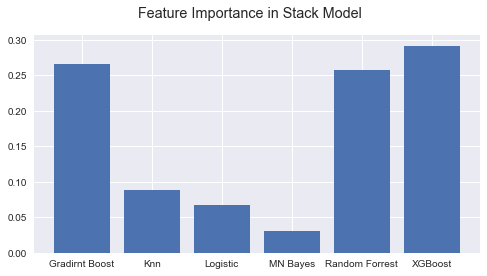

In [172]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x_clfs, grid_random_stack.best_estimator_.feature_importances_)
ax.grid
fig.suptitle('Feature Importance in Stack Model')

In [170]:
scores_random_stack = cross_val_score(grid_random_stack.best_estimator_, X_train_oof_final, y, cv=cv_splitter, n_jobs=-1)
print(scores_random_stack)
print('Mean (random): '+str(scores_random_stack.mean()))
print('SD (random): '+str(scores_random_stack.std()))

[0.8547486  0.83798883 0.83707865 0.80898876 0.8700565 ]
Mean (random): 0.8417722686146151
SD (random): 0.020393555315705667


### 9. Compare results of all 7 models

In [173]:
cross_val_results_all = pd.Series([scores_logis, scores_random, scores_gradient, 
                       scores_xgb, scores_mnb, scores_knn, scores_random_stack], 
            index=['Logistic', 'Random Forrest', 'Gradirnt Boost', 'XGBoost', 'MN Bayes', 'Knn', 
                   'Stack'])

Text(0.5,0.98,'Mean of Cross-Validation Scores')

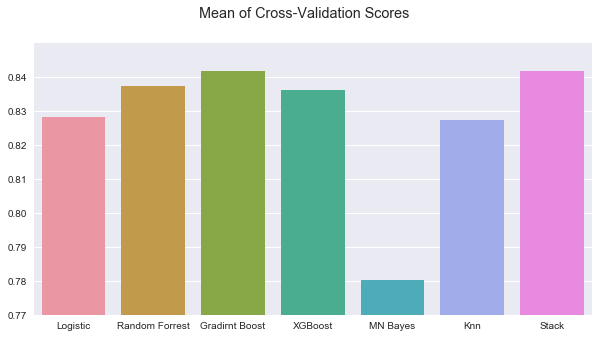

In [180]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=cross_val_results_all.index, y=cross_val_results_all.apply(np.mean))
ax.set_ylim(0.77, 0.85)
ax.set_yticks(np.arange(0.77, 0.85, step=0.01))
fig.suptitle('Mean of Cross-Validation Scores')

Text(0.5,0.98,'Standard Deviation of Cross-Validation Scores')

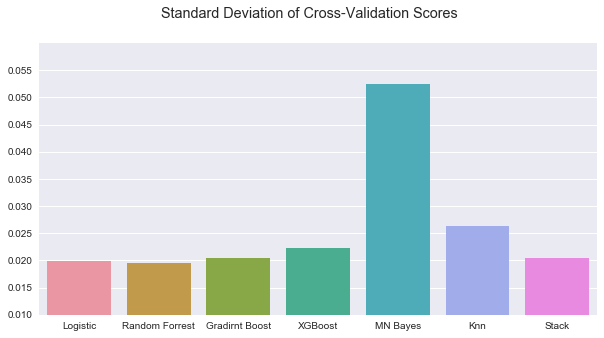

In [181]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=cross_val_results_all.index, y=cross_val_results_all.apply(np.std))
ax.set_ylim(0.01, 0.06)
ax.set_yticks(np.arange(0.01, 0.06, step=0.005))
fig.suptitle('Standard Deviation of Cross-Validation Scores')

## Model Predictions

### 1. Logistic regression

In [ ]:
y_test_predict_logis = grid_logis.predict(X_test)
submission_logis_2 = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_test_predict_logis})

existing_file = glob.glob('submission_logis_2.csv')
assert (not existing_file), 'File already existed.'
submission_logis_2.to_csv('submission_logis_2.csv', index=False)
# (This submission got a public score of 0.794)

### 2. Random forrest

In [ ]:
y_test_predict_random = grid_random.predict(X_test)
submission_random_2 = pd.DataFrame({'PassengerId': passenger_id, 
                                    'Survived': y_test_predict_random})

existing_file = glob.glob('submission_random_2.csv')
assert (not existing_file), 'File already existed.'
submission_random_2.to_csv('submission_random_2.csv', index=False)
# (This submission got a public score of 0.799)

### 3. Gradient boosting

In [ ]:
y_test_predict_gradient = grid_gradient.predict(X_test)
submission_gradient_2 = pd.DataFrame({'PassengerId': passenger_id, 
                                      'Survived': y_test_predict_gradient})

existing_file = glob.glob('submission_gradient_2.csv')
assert (not existing_file), 'File already existed.'
submission_gradient_2.to_csv('submission_gradient_2.csv', index=False)
# (This submission got a public score of 0.794)

### 4. XGboost

In [ ]:
y_test_predict_xgb = grid_xgb.predict(X_test)
submission_xgb_2 = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_test_predict_xgb})

existing_file = glob.glob('submission_xgb_2.csv')
assert (not existing_file), 'File already existed.'
submission_xgb_2.to_csv('submission_xgb_2.csv', index=False)
# (This submission got a public score of 0.794)

### 5. Multinomial Naive Bayes

In [ ]:
y_test_predict_mnb = grid_mnb.predict(X_test)
submission_mnb_2 = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_test_predict_mnb})

existing_file = glob.glob('submission_mnb_2.csv')
assert (not existing_file), 'File already existed.'
submission_mnb_2.to_csv('submission_mnb_2.csv', index=False)
# (This submission got a public score of 0.746)

### 6. K Neareat Neighbors

In [ ]:
y_test_predict_knn = grid_knn.predict(X_test)
submission_knn_2 = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_test_predict_knn})

existing_file = glob.glob('submission_knn_2.csv')
assert (not existing_file), 'File already existed.'
submission_knn_2.to_csv('submission_knn_2.csv', index=False)
# (This submission got a public score of 0.789)

### 7. Stack

In [ ]:
y_test_predict_random_stack = grid_random_stack.predict(X_test_oof_final)
submission_stack_2 = pd.DataFrame({'PassengerId': passenger_id, 
                                   'Survived':y_test_predict_random_stack})

existing_file = glob.glob('submission_stack_2.csv')
assert (not existing_file), 'File already existed.'
submission_stack_2.to_csv('submission_stack_2.csv', index=False)
# (This submission got a public score of 0.799)

### 8. Finally perform a majority vote using all 7 model predictions

In [ ]:
predict_array = np.array([y_test_predict_logis, y_test_predict_random, y_test_predict_gradient, 
                    y_test_predict_xgb, y_test_predict_mnb, y_test_predict_knn, 
                    y_test_predict_random_stack])

In [ ]:
vote_df = pd.DataFrame(predict_array, index=['Logistic', 'Random Forrest', 'Gradirnt Boost', 
                                           'XGBoost', 'MN Bayes', 'Knn', 'Stack'])

In [ ]:
y_test_predict_vote = np.array(vote_df.mode(axis=0))[0]

In [ ]:
submission_vote_2 = pd.DataFrame({'PassengerId': passenger_id, 'Survived': y_test_predict_vote})

existing_file = glob.glob('submission_vote_2.csv')
assert (not existing_file), 'File already existed.'
submission_vote_2.to_csv('submission_vote_2.csv', index=False)
# (This submission got a public score of 0.799)

### 9. Public score comparison

In [ ]:
fig, ax = plt.subplots(figsize=(11, 5))
ax.set_ylim(0.735, 0.805)
ax.set_yticks(np.arange(0.735, 0.805, step=0.01))
sns.barplot(x=['Logistic', 'Random Forrest', 'Gradirnt Boost', 'XGBoost', 'MN Bayes', 'Knn', 
           'Stack', 'Vote'], y=[0.794, 0.799, 0.794, 0.794, 0.746, 0.789, 0.799, 0.799])

In [22]:
pwd

'C:\\Users\\tony3\\OneDrive\\Documents\\Titanic'

In [27]:
test = pd.read_csv('submission_xgb_2_Kaggle.csv')
test_array = np.array(test['Survived'])
test_array

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [28]:
# compare with Kaggle with submission_xgb_2.csv
p = np.equal([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1], 
            [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])
[i for i in p if ~i]

[]